This code is meant to test the potential effect of numu disappearence on the nue.
This can be compared to the global fit region.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
from math import sqrt,cos,acos,pi,exp,sin,atan2,log
from numpy import arange,mean,asarray,isnan,isinf
import pickle as pkl
from scipy import stats

import csv
import sys
import pandas as pd
import os

#Binary Settings
sys     = True
usedata = False
shapeonly = False
makeCutData = False
ntestbins =25

Nickdir = '/home/kmason/fullosc/NicksCode/1L1PSelection/1e1pBDT/'

finalPred = False
fset = 12 # 0 = open data, 1-7 = fake datasets, 8 = High E far sideband, 9 = Low BDT far sideband, 10 = Full near sideband
cutMode = 0 # 0 = Final Selection, 1 = Kin Cut Sample, 2 = High E, 3 = Low BDT, 4 = 
if fset==8: cutMode = 2
if fset==9: cutMode = 3
    
cutmodedir = {0:'FinalSelection',1:'KinCut',2:'HighE',3:'LowBDT'}[cutMode]

lowEpatch = False#True if fset in [0,5,8,9] else False
vtxCut    = 5#np.inf

C1_POT = 1.558e+20 + 1.129e+17 + 1.869e+19
D2_POT = 1.63e+20 + 2.964e+19 + 1.239e+19
E1_POT = 5.923e+19
F1_POT = 4.3e+19
G1_POT = 1.701e+20 + 2.97e+19 + 1.524e+17


if fset==0: 
    DAT_POT1 = 4.403e19
    DAT_POT2 = 0
    DAT_POT3 = 8.786e+18
elif fset==1: 
    DAT_POT1  = 1.935765e20
    DAT_POT2 = 0
    DAT_POT3  = 2.99974063e20
elif fset==2: 
    DAT_POT1 = 4.0129213616e20
    DAT_POT2 = 0
    DAT_POT3 = 3.85169302616e20
elif fset==3: 
    DAT_POT1 = 4.024614415411e20
    DAT_POT2 = 0
    DAT_POT3 = 3.9685728933181e20
elif fset==4: 
    DAT_POT1 = 3.907905653e20
    DAT_POT2 = 0
    DAT_POT3 = 3.92356759e20
elif fset==5: 
    DAT_POT1 = 7.00587e20
    DAT_POT2 = 0
    DAT_POT3 = 0
elif fset==7: 
    DAT_POT1 = 1.8382999360024655e+20
    DAT_POT2 = 0
    DAT_POT3 = 2.05E+20
elif(fset==8):
    DAT_POT1 = C1_POT
    DAT_POT2 = D2_POT+E1_POT
    DAT_POT3 = F1_POT+G1_POT
elif(fset==9):
    DAT_POT1 = C1_POT
    DAT_POT2 = D2_POT+E1_POT
    DAT_POT3 = G1_POT
elif(fset ==10):
    DAT_POT1 = 1.631e+20
    DAT_POT2 = 2.750e+20
    DAT_POT3 = 2.291e+20
elif(fset ==11):
    DAT_POT1 = 1.69E+20
    DAT_POT2 = 2.73E+20
    DAT_POT3 = 2.44E+20
elif(fset ==12):
    DAT_POT1 = 1.631e+20
    DAT_POT2 = 2.750e+20
    DAT_POT3 = 2.291e+20

if finalPred and fset==0:
    DAT_POT1 = C1_POT
    DAT_POT2 = E1_POT+D2_POT
    DAT_POT3 = F1_POT+G1_POT
    
DATA_POT_TOT = DAT_POT1 + DAT_POT2 + DAT_POT3


print(DAT_POT1,DAT_POT2,DAT_POT3)
print(DAT_POT1+DAT_POT2+DAT_POT3)

def poisson_errors(k, CL = 0.6827):
    
    # 1 Sig = 0.6827
    # 2 Sig = 0.9545
    # 3 Sig = 0.9973
    
    a = 1.0 - CL
    low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
    low = np.where(k==0,0,low)
    return k - low, high - k


1.631e+20 2.75e+20 2.291e+20
6.672e+20


In [2]:
tag='23Aug2021_vA_fullLowE_withPi0Sample_newShowerCalib'
#tag='7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu'

filetaglist = {1:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0'],
               2:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE'],
               3:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0']}

df = {1:{},2:{},3:{}}

psavedir = 'Parquets/'+tag+'/'

for r in [1,2,3]:
    print('\n\n','#'*20,'RUN',r,'#'*20,'\n')

    for filetag in filetaglist[r]:
        if not lowEpatch and 'lowE' in filetag: continue
        print('Sample:',filetag)
        if filetag=='data':
            pstring = 'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,fset,r)
        else:
            pstring = 'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,fset,r)
        try:
            df[r][filetag] = pd.read_parquet(psavedir+pstring)
            print(len(df[r][filetag]))
        except:
            print('No Events')
            pass
        
df[2]['ext'] = df[3]['ext'].copy()
if cutMode in [2,3]:
    df1d = (df[1]['data'].copy()).query('run<8000')
    df2d = (df[1]['data'].copy()).query('run>8000 and run<13000')
    df3d = (df[1]['data'].copy()).query('run>13000')
    df[1]['data'] = df1d
    df[2]['data'] = df2d
    df[3]['data'] = df3d

dftest = df[1]['data'].query('run == 5589')



 #################### RUN 1 #################### 

Sample: data
5464
Sample: ext
263
Sample: overlay
5602
Sample: intrinsics
14733
Sample: ncpi0
589
Sample: ccpi0
285


 #################### RUN 2 #################### 

Sample: data
No Events
Sample: ext
No Events
Sample: overlay
5784
Sample: intrinsics
11241


 #################### RUN 3 #################### 

Sample: data
No Events
Sample: ext
537
Sample: overlay
3943
Sample: intrinsics
5940
Sample: ncpi0
504
Sample: ccpi0
5


In [3]:
varb_names = ['Enu_1e1p','Eta','PT_1e1p','AlphaT_1e1p',
              'SphB_1e1p','PzEnu_1e1p','ChargeNearTrunk',
              'Q0_1e1p','Q3_1e1p','Thetas','Phis','PTRat_1e1p',
              'Proton_ThetaReco','Proton_PhiReco',
              'MinShrFrac','MaxShrFrac',
              'BjXB_1e1p','BjYB_1e1p','Proton_Edep',
              'Electron_Edep',
              'Lepton_ThetaReco','Lepton_PhiReco',
              'OpenAng','Xreco','Yreco','Zreco',
              'sigprob','MPIDY_muon',
              'MPIDY_proton','MPIDY_eminus','shower_fraction',
              'Shower_Consistency',
              'EnuQE_lepton','EnuQE_proton',
              'Proton_TrackLength','Lepton_TrackLength','EnuTrue']

var_labels = [r'$E_\nu^{Range}$ [MeV]',r'$\eta$',r'Event $p_T$ [MeV]',r'$\alpha_T$',
              'QE Consistency',r'$p_z - E_\nu$ [MeV]','Charge Near Trunk',
              r'$Q_0$ [MeV]',r'$Q_3$ [MeV]',r'$\theta_e + \theta_p$',r'$|\phi_e - \phi_p|$',r'Event $p_T/p$',
              r'$\theta_p$',r'$\phi_p$',
              'Minimum Shower Fraction','Maximum Shower Fraction',
              'Bjorken X (Nucleon Rest Frame)','Bjorken Y (Nucleon Rest Frame)',r'$E_p$ [MeV]',
              r'$E_e$ [MeV]',
              r'$\theta_e$',r'$\phi_e$',
              'Opening Angle',r'$X_{reco}$',r'$Y_{reco}$','$Z_{reco}$',
              '1e1p BDT Score','Muon MPID Score (Y plane)',
              'Proton MPID Score (Y plane)','Electron MPID Score (Y plane)','Shower Fraction',
              'Shower Energy Consistency',
              r'$E_\nu^{Q-e}$',r'$E_\nu^{QE-p}$',
              'Proton Track Length [cm]','Lepton Track Length [cm]',r'$E_\nu^{True}$ [MeV]']

ranges = [ (200,2200),(0,0.6),(0,800),(0,np.pi),(0,5000),(-800,300),
           (0,800),(100,700),(0,1400),(0,2*np.pi),(0,2*np.pi),
           (0,1),(0,np.pi),(-np.pi,np.pi),(-1,1),(-1,1),(0,3),
           (0,1),(60,500),(35,1200),(0,np.pi),
           (-np.pi,np.pi),(0,np.pi),(0,256),(-117,117),(0,1036),
           (0.0,1.0),(0,1),(0,1),(0,1),(0,3),(0,5),
           (0,1200),(0,1200),(0,100),(0,200),(0,1200)]

varlabel_dict = {name:label for name,label in zip(varb_names,var_labels)}
range_dict = {name:rnge for name,rnge in zip(varb_names,ranges)}

if cutMode in [0,2]: range_dict['sigprob'] = (0.95,1.0)
    

In [4]:
# HELPER FUNCTIONS
detsystag = '1April2021'
dettag='3March2021_vA_fullLowE_withPi0Sample_newShowerCalib'
def getSysErrors(nbins,varName,mode,sigcut,rwtnameoverride=None,nsbmode=3):
    det_sys_m = np.loadtxt(Nickdir+'CovMatrices/DetVar/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/7September2021/covMatrix/avgscore/BDTcut0.95/detsys_Enu_1e1p_run13_cutMode0_cov_smooth.csv',delimiter=',')
#     det_sys_m = np.zeros((12,12))
    rwt_sys_m = np.loadtxt(Nickdir+'CovMatrices/RwghtSys/frac_covar_rewgt_highE.txt')
#     rwt_sys_m = np.zeros((12,12))
    rwt_sys_m = np.where(np.isnan(rwt_sys_m),0,rwt_sys_m)
    det_sys_m = np.where(np.isnan(det_sys_m),0,det_sys_m)
    return rwt_sys_m, det_sys_m

def getDetSysTot(det_sys_nue,nue,numu):
#     print(det_sys_nue)
    det_sys_numu = np.diag(0.04*np.ones(det_sys_nue.shape[0]))
#     print(det_sys_numu)
#     print(nue)
#     print(numu)
    tot = nue+numu
    return (det_sys_nue * np.outer(nue,nue) + det_sys_numu * np.outer(numu,numu))/np.outer(tot,tot)
    

def MakeBDTcut(idf,sigcut,mode,nBDTs,r2overlay=False,ttc=0.1):
    
    # Conglemerate BDT scores and weights based on strategy 
    
    bdtweight = np.zeros(idf.shape[0])
    sigprobmax = np.zeros(idf.shape[0]) 
    sigprobavg = np.zeros(idf.shape[0])
    sigprobmedian = np.zeros(idf.shape[0])
    sigproblist = np.zeros((idf.shape[0],nBDTs))
    notintrain = np.zeros((idf.shape[0],nBDTs),dtype=bool)
    numnottrain = np.zeros(idf.shape[0])
    for b in range(nBDTs):
        sp = idf['sigprob%i'%b]
        tvw = idf['tvweight%i'%b]
        sigprobmax = np.where(np.logical_and(tvw>0,sp>sigprobmax),sp,sigprobmax) # cut on the maximum non-train score in ensemble
        if mode == 'fracweight': 
            #bdtweight += np.where(sp>sigcut,tvw/float(nBDTs),0)
            bdtweight += np.where((tvw>ttc) & (sp>sigcut),1.0,0.0)
        sigprobavg += np.where(tvw>ttc,sp,0)
        numnottrain += np.where(tvw>ttc,1,0)
        sigproblist[:,b] = sp
        notintrain[:,b] = tvw > ttc
    sigprobavg /= np.where(numnottrain>0,numnottrain,1)
    for i,(tlist,siglist) in enumerate(zip(notintrain,sigproblist)):
        splist = siglist[tlist]
        if splist.size!=0: sigprobmedian[i] = np.median(splist)
        else: sigprobmedian[i] = 0
        
    idf['sigprobavg'] = sigprobavg
    idf['sigprobmedian'] = sigprobmedian
    idf['sigprobmax'] = sigprobmax

    
    if mode == 'avgscore':
        idf['sigprob'] = idf['sigprobavg']
        bdtweight = np.where(sigprobavg>sigcut,1,0)
    elif mode == 'medianscore':
        idf['sigprob'] = idf['sigprobmedian']
        bdtweight = np.where(sigprobmedian>sigcut,1,0)
    elif mode == 'fracweight':
        idf['sigprob'] = idf['sigprobmax']
        bdtweight /= np.where(numnottrain>0,numnottrain,1)
    
    idf['bdtweight'] = bdtweight
    
    # Drop duplicates
    
    idf.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
    if r2overlay:
        idf.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
    else:
        idf.drop_duplicates(subset=['run','subrun','event'],inplace=True)
    
def SaveTextFile(idf,run,filetag,sigcut,mode,tsavedir):
    nBDTs = int(idf['nBDTs'][0])
    MakeBDTcut(idf,sigcut,mode,nBDTs)
    idf.query('sigprob > @sigcut',inplace=True)
    savestr = 'eventlist_%s_run%i.txt'%(filetag,run)
    idf.to_csv(tsavedir+savestr,index=None,sep=' ')
    

# function to save full osc probabilities - adjusted for disappearence
def oscweights(df,sin22,m41):
    weights = [] 
    m =m41
    for i in range(len(df)):

        label = df["label"].values[i]
        P=0
        if("numu" in label):
            E=df['EnuTrue'].values[i]*1e-3
            z = df['Zreco'].values[i]*.01 - 5
            L= .47+(z*.001)

            sin2 = math.sin(1.27*((m*L)/E))
            sin1 = sin(sin22*2)
            P = 1-sin2*sin2*sin22
        else:
            P=1
        weights.append(P)

        
    return weights
    
    

In [5]:
mu_cutoff = 0.46149198646840239

def chi2_cnp(M,mu):
    c2c=0
    if mu>0:
        if M != 0:
            c2c = (M - mu)**2/(3 / (2 / mu + 1 / M))
        else:
            c2c = mu/2#(M - mu)**2/(3 / (2 / mu + 1 / mu))
    return c2c

def chi2_pois(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = 2*(mu - M + M*np.log(M/mu))
        else:
            c2c = 2*mu
    return c2c

def chi2_pears(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = (M-mu)**2 / mu
        else:
            c2c = 2*mu
    return c2c

def chi2_thresh(M,mu,mode='cnp'):
    c2c=0
    if mu > mu_cutoff and mode=='cnp':
        c2c = chi2_cnp(M,mu)
    elif mu > mu_cutoff and mode=='pearson':
        c2c = chi2_pears(M,mu)
    else:
        c2c = chi2_pois(M,mu)
    return c2c

def cov_pois(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (M-mu)**2 / (2*(mu - M + M*np.log(M/mu)))
        else:
            cov = mu/2
    return cov

def cov_cnp(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (3 / (2 / mu + 1 / M))
        else:
            cov = mu/2
    return cov

def cov_pears(M,mu):
    cov=0
    if mu > 0:
        cov = mu
    return cov

def cov_thresh(M,mu,mode='cnp'):
    cov=0
    if mu>mu_cutoff and mode=='cnp':
        cov=cov_cnp(M,mu)
    elif mu>mu_cutoff and mode=='pearson':
        cov=cov_pears(M,mu)
    else:
        cov=cov_pois(M,mu)
    return cov

def getnormalizationunc(det_sys_m,rwt_sys_m,p):
    msys = det_sys_m+rwt_sys_m
    f_unc = (sum(sum(msys)))/(sum(p)**2)
    print("func",f_unc,(sum(p)),(sum(sum(msys))))
    return f_unc


indexing: 0 0
indexing: 0 1
indexing: 0 2
indexing: 0 3
indexing: 0 4
indexing: 0 5
indexing: 0 6
indexing: 0 7
indexing: 0 8
indexing: 0 9
indexing: 0 10
indexing: 0 11
indexing: 0 12
indexing: 0 13
indexing: 0 14
indexing: 0 15
indexing: 0 16
indexing: 0 17
indexing: 0 18
indexing: 0 19
indexing: 0 20
indexing: 0 21
indexing: 0 22
indexing: 0 23
indexing: 0 24
indexing: 1 0
indexing: 1 1
indexing: 1 2
indexing: 1 3
indexing: 1 4
indexing: 1 5
indexing: 1 6
indexing: 1 7
indexing: 1 8
indexing: 1 9
indexing: 1 10
indexing: 1 11
indexing: 1 12
indexing: 1 13
indexing: 1 14
indexing: 1 15
indexing: 1 16
indexing: 1 17
indexing: 1 18
indexing: 1 19
indexing: 1 20
indexing: 1 21
indexing: 1 22
indexing: 1 23
indexing: 1 24
indexing: 2 0
indexing: 2 1
indexing: 2 2
indexing: 2 3
indexing: 2 4
indexing: 2 5
indexing: 2 6
indexing: 2 7
indexing: 2 8
indexing: 2 9
indexing: 2 10
indexing: 2 11
indexing: 2 12
indexing: 2 13
indexing: 2 14
indexing: 2 15
indexing: 2 16
indexing: 2 17
indexing: 

indexing: 21 17
indexing: 21 18
indexing: 21 19
indexing: 21 20
indexing: 21 21
indexing: 21 22
indexing: 21 23
indexing: 21 24
indexing: 22 0
indexing: 22 1
indexing: 22 2
indexing: 22 3
indexing: 22 4
indexing: 22 5
indexing: 22 6
indexing: 22 7
indexing: 22 8
indexing: 22 9
indexing: 22 10
indexing: 22 11
indexing: 22 12
indexing: 22 13
indexing: 22 14
indexing: 22 15
indexing: 22 16
indexing: 22 17
indexing: 22 18
indexing: 22 19
indexing: 22 20
indexing: 22 21
indexing: 22 22
indexing: 22 23
indexing: 22 24
indexing: 23 0
indexing: 23 1
indexing: 23 2
indexing: 23 3
indexing: 23 4
indexing: 23 5
indexing: 23 6
indexing: 23 7
indexing: 23 8
indexing: 23 9
indexing: 23 10
indexing: 23 11
indexing: 23 12
indexing: 23 13
indexing: 23 14
indexing: 23 15
indexing: 23 16
indexing: 23 17
indexing: 23 18
indexing: 23 19
indexing: 23 20
indexing: 23 21
indexing: 23 22
indexing: 23 23
indexing: 23 24
indexing: 24 0
indexing: 24 1
indexing: 24 2
indexing: 24 3
indexing: 24 4
indexing: 24 5
in

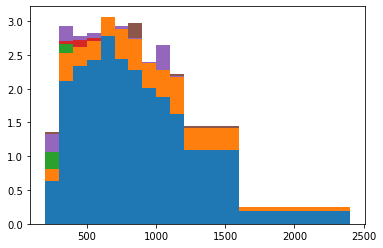

In [6]:
fudge_bkg = 1.0
fudge_sig = 1.0

plot_thresh = 0.05

# Near sideband stuff
nsbmode = 0 # 1 = Enu>500, 2 = 500<Enu<700, 3 = 0.7 < BDT < 0.95, 4 = 0.01 < BDT < 0.95
nsbrwtovr = None
if nsbmode in [1,2,3]: nsbrwtovr = 'samp%i'%nsbmode
if nsbmode==3:
    range_dict['sigprob'] = (0.7,0.95)
elif nsbmode==4:
    range_dict['sigprob'] = (0.01,0.95)
elif nsbmode in [0,1,2]:
    range_dict['sigprob'] = (0.95,1.0)

 

#BDT Settings
bdtmode = 'avgscore'
nBDTs = 20
bdtpower = 0
bdtcutRange = [range_dict['sigprob'][0]]

runs_to_plot = [[1,2,3]]

POTdict = {1:{ft:DAT_POT1 for ft in filetaglist[1]},
           2:{ft:DAT_POT2 for ft in filetaglist[2]},
           3:{ft:DAT_POT3 for ft in filetaglist[3]}}

if cutMode in [2,3] or fset==12: 
    POTdict[1]['data'] = DATA_POT_TOT
    POTdict[2]['data'] = DATA_POT_TOT
    POTdict[3]['data'] = DATA_POT_TOT
    
pvalsa = []
pvalsf = []

cls  = ['deeppink','purple','blue','cyan','darkgreen','greenyellow','gold','brown','gray','fuchsia']

# make lists of sin22theta and m41
sin22theta_list = np.logspace(.1, 4, ntestbins, endpoint=True)
for i in range(len(sin22theta_list)):
    sin22theta_list[i]= sin22theta_list[i]*.0001

m41_list = np.logspace(.1, 4, ntestbins, endpoint=True)
for i in range(len(m41_list)):
    m41_list[i]= m41_list[i]*.01
    
chi2_list = np.zeros((ntestbins, ntestbins))
bestm =-999
bests = -999
bestchi = 100000000

for m in range(len(m41_list)):
    m41=m41_list[m]
    for s in range(len(sin22theta_list)):
        sin41=sin22theta_list[s]
        # print statement to track progress
        print("indexing:",m,s)
        varName = 'Enu_1e1p'
        bins  = [200,300,400,500,600,700,800,900,1000,1100,1200,1600,2400]
        numbins = len(bins)-1
        xlab = varlabel_dict[varName]
        low   = (range_dict[varName])[0]
        high  = (range_dict[varName])[1]

        for runs_included in runs_to_plot: # [run 1, run 2 run 3]

            pRatDict = {}
            pErrDict = {}

            for cut in bdtcutRange:

                if cutMode in [0,2] and varName=='sigprob': low = cut

                plotTitle = 'Low BDT Sideband | Runs:'
                plotFileName = varName
                FullPOT = 0
                POT1 = 0
                POT23 = 0

                vars_arr = []
                weights_arr = []
                labels_arr = []
                leew_arr = []
                Enu_arr = []

                dflist = []
                dfdat = pd.DataFrame()
                dflee = pd.DataFrame()
                dftot = pd.DataFrame()

                bkginttype = {}
                onvbkginttype = {}
                offvbkginttype = {}

                for r in runs_included:
                    plotTitle += ' %i'%r
                    plotFileName += '_%i'%r
                    FullPOT += POTdict[r]['overlay']
                    if r == 1: POT1 += POTdict[r]['overlay']
                    elif r in [2,3]: POT23 += POTdict[r]['overlay']

                    for filetag in df[r].keys():
                        if not lowEpatch and 'lowE' in filetag: continue
                        if finalPred and filetag=='data': continue
                        dfc = df[r][filetag].copy()

                        if filetag!='data' or makeCutData:
                            MakeBDTcut(dfc,cut,bdtmode,nBDTs,(r==2 and filetag=='overlay'),ttc=0.1)
                        else:
                            dfc['sigprob'] = dfc['BDTscore_1e1p']
                            dfc['bdtweight'] = np.where(np.array(dfc['sigprob'])>cut,1,0)
                            dfc.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
                            if r==2 and filetag=='overlay':
                                dfc.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
                            else:
                                dfc.drop_duplicates(subset=['run','subrun','event'],inplace=True)


                        vars_arr += list(dfc[varName])
                        Enu_arr += list(dfc['Enu_1e1p'])
                        numu_l = np.core.defchararray.find(np.array(dfc['label'],dtype=np.string_),'m')!=-1
                        labels = np.where(np.logical_and(numu_l,dfc['scedr']>vtxCut),'offvtx',dfc['label'])

                        dfc['label'] = labels
                        labels_arr += list(labels)

                        oscprob=oscweights(dfc,sin41,m41)
                        dfc['oscprob']=oscprob
                     

                        weights = dfc['GenieWeight'] * dfc['oscprob'] * dfc['POTweight']**(-1)
                        if cutMode in [0,2]: weights*= dfc['bdtweight'] * dfc['sigprob']**bdtpower
                        weights*=dfc['sigprob']>range_dict['sigprob'][0]
                        weights*=dfc['sigprob']<range_dict['sigprob'][1]
                        if nsbmode in [1,2]: weights*=dfc['Enu_1e1p']>500
                        if nsbmode==2: weights*=dfc['Enu_1e1p']<700
                        weights*=dfc['Enu_1e1p']<range_dict['Enu_1e1p'][1]
#                               add in weights for different binning
                        binweights=np.ones(len(weights))
                        for i in range(len(weights)):
                            enu = dfc['Enu_1e1p'].values[i]
                            if(enu<=1600 and enu>1200 ): 
                                binweights[i]*=1.0/4.0
                            if(enu>1600 and enu<=2400 ): 
                                binweights[i]*=1.0/8.0
                        weights*=binweights
                    

                        leeweights = dfc['LEEweight'] * weights

                        if filetag!='intrinsics': leeweights*=0

                        weights_arr += list(weights*POTdict[r][filetag])
                        leew_arr += list(leeweights*POTdict[r][filetag])

                        dfc_lee = dfc.copy()
                        dfc['weights'] = weights*POTdict[r][filetag]
                        dfc_lee['weights'] = leeweights*POTdict[r][filetag]

                        if filetag=='data':
                            dfdat = pd.concat((dfdat,dfc.query('weights>0')))
                        else:
                            dflee = pd.concat((dflee,dfc_lee))
                            dftot = pd.concat((dftot,dfc))
                            dflist.append(dfc)


                datLab = "Data: {:.2e} POT".format(FullPOT)
                if(sys):
                    rwt_sys_m,det_sys_m = getSysErrors(bins,varName,bdtmode,cut,rwtnameoverride=nsbrwtovr,nsbmode=nsbmode)
                    sys_label = 'Full Systematics + MC Stat'
                else:
                    rwt_sys_m = np.zeros((numbins,numbins))
                    det_sys_m = np.zeros((numbins,numbins))
                    sys_label = 'MC Stat'


                label_arr = np.array(labels_arr)
                var_arr = np.array(vars_arr)
                enu_arr = np.array(Enu_arr)
                weight_arr = np.array(weights_arr)

                data = list(var_arr[label_arr=='data'])
                if nsbmode==1: dataOld = list(var_arr[np.logical_and(label_arr=='data',enu_arr>700)])
                nueO = list(var_arr[label_arr=='nue_ccqe'])
                nue = list(var_arr[label_arr=='nue_other'])
                ccqe = list(var_arr[label_arr=='numu_ccqe'])
                mec = list(var_arr[label_arr=='numu_mec'])
                pipm = list(var_arr[label_arr=='numu_pipm'])
                pi0 = list(var_arr[label_arr=='numu_pi0'])
                other = list(var_arr[label_arr=='numu_other'])
                dirtVar = []
                offv = list(var_arr[label_arr=='offvtx'])
                extVar = list(var_arr[label_arr=='EXTBNB'])
                lee = list(var_arr)

                ovrw1 = list(fudge_bkg*weight_arr[label_arr=='numu_ccqe'])
                ovrw2 = list(fudge_bkg*weight_arr[label_arr=='numu_mec'])
                ovrw3 = list(fudge_bkg*weight_arr[label_arr=='numu_pipm'])
                ovrw4 = list(fudge_bkg*weight_arr[label_arr=='numu_pi0'])
                ovrw5 = list(fudge_bkg*weight_arr[label_arr=='numu_other'])
                ovrw6 = list(fudge_bkg*weight_arr[label_arr=='offvtx'])
                ovrw7 = list(fudge_sig*weight_arr[label_arr=='nue_other'])
                ovrw8 = list(fudge_sig*weight_arr[label_arr=='nue_ccqe'])
                dirtw = []
                extw = list(weight_arr[label_arr=='EXTBNB'])
                leew = leew_arr
                datw = list(weight_arr[label_arr=='data'])
            
            if (usedata):
                d = plt.hist(data,weights=datw,bins=bins,range=(low,high),density=0)
                xbins  = [(d[1][i]+d[1][i+1])/2.0 for i in range(len(d[1])-1)]
                xbin_edges = d[1]
                vals = d[0]
                valerrs = poisson_errors(vals)
                binwid = [50,50,50,50,50,50,50,50,50,50,200,400]
            else:
                d = [1.77,3.29,2.84,2.84,3.06,2.90,3.00,2.52,2.45,2.19,1.54,0.25]
                xbins  = [(bins[i]+bins[i+1])/2.0 for i in range(numbins)]
                xbin_edges = bins
                vals = np.array(d)
                valerrs = poisson_errors(vals)
                binwid = [50,50,50,50,50,50,50,50,50,50,200,400]
              
                
                plt.clf()

                wghs = [[x for x in ovrw8],
                        [x for x in ovrw7],
                        [x for x in ovrw1],
                        [x for x in  ovrw2],
                        [x for x in ovrw3],
                        [x for x in  ovrw4],
                        [x for x in ovrw5],
                        [x for x in dirtw],
                        [x for x in ovrw6],
                        [x for x in extw],
                        [x for x in leew]]

                mcErW = [[x**2 for x in ovrw8],
                         [x**2 for x in ovrw7],
                         [x**2 for x in ovrw1],
                         [x**2 for x in  ovrw2],
                         [x**2 for x in ovrw3],
                         [x**2 for x in  ovrw4],
                         [x**2 for x in ovrw5],
                         [x**2 for x in dirtw],
                         [x**2 for x in ovrw6],
                         [x**2 for x in extw]]



                r = plt.hist([nueO,nue,ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar],bins=bins,range=(low,high),stacked='True',density=0,weights=mcErW)
                nueO_mcErr  = [sqrt(r[0][0][i]- 0) for i in range(numbins)]
                nue_mcErr   = [sqrt(r[0][1][i]-r[0][0][i]) for i in range(numbins)]
                ccqe_mcErr  = [sqrt(r[0][2][i]-r[0][1][i]) for i in range(numbins)]
                mec_mcErr   = [sqrt(r[0][3][i]-r[0][2][i]) for i in range(numbins)]
                pipm_mcErr  = [sqrt(r[0][4][i]-r[0][3][i]) for i in range(numbins)]
                pi0_mcErr   = [sqrt(r[0][5][i]-r[0][4][i]) for i in range(numbins)]
                other_mcErr = [sqrt(r[0][6][i]-r[0][5][i]) for i in range(numbins)]
                dirt_mcErr  = [sqrt(r[0][7][i]-r[0][6][i]) for i in range(numbins)]
                offv_mcErr  = [sqrt(r[0][8][i]-r[0][7][i]) for i in range(numbins)]
                ext_mcErr   = [sqrt(r[0][9][i]-r[0][8][i]) for i in range(numbins)]
                stkerr =  [sqrt( 
                           nueO_mcErr[i]**2  + 
                           nue_mcErr[i]**2  + 
                           ccqe_mcErr[i]**2  + 
                           mec_mcErr[i]**2  + 
                           pipm_mcErr[i]**2  + 
                           pi0_mcErr[i]**2  + 
                           other_mcErr[i]**2  + 
                           dirt_mcErr[i]**2 + 
                           offv_mcErr[i]**2 +  
                           ext_mcErr[i]**2 )
                           for i in range(numbins) 
                          ]
                stkerr = np.array(stkerr)
                bkgErr = sum([ (ccqe_mcErr[i]**2  + 
                           mec_mcErr[i]**2  + 
                           pipm_mcErr[i]**2  + 
                           pi0_mcErr[i]**2  + 
                           other_mcErr[i]**2  + 
                           dirt_mcErr[i]**2 + 
                           offv_mcErr[i]**2 +  
                           ext_mcErr[i]**2 )
                           for i in range(numbins) 
                          ])
                if (not usedata):
                    valerrs = stkerr
                plt.clf()

                pli = plt.hist([nueO,nue,ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar,lee],bins=bins,range=(low,high),weights=wghs,stacked='True',density=0)
                plt.clf()

                nums = [sum(x for x in pli[0][0]           ),
                        sum(x for x in pli[0][1] -pli[0][0]),
                        sum(x for x in pli[0][2] -pli[0][1]),
                        sum(x for x in pli[0][3] -pli[0][2]),
                        sum(x for x in pli[0][4] -pli[0][3]),
                        sum(x for x in pli[0][5] -pli[0][4]),
                        sum(x for x in pli[0][6] -pli[0][5]),
                        sum(x for x in pli[0][7] -pli[0][6]),
                        sum(x for x in pli[0][8] -pli[0][7]),
                        sum(x for x in pli[0][9] -pli[0][8]),        
                        sum(x for x in pli[0][10]-pli[0][9]),
                        sum(x for x in vals)
                        ]


                labs = [r'$\nu_e^{ }$ CCQE (%.1f)'%nums[0],
                        r'$\nu_e^{ }$ Other (%.1f)'%nums[1],
                        r"$\nu_\mu^{ }$ CCQE (%.1f)"%nums[2],
                        r"$\nu_\mu$ MEC (%.1f)"%nums[3],
                        r"$\nu_\mu$ Res $\pi^{\pm}$ (%.1f)"%nums[4],
                        r"$\nu_\mu$ Res $\pi^0$ (%.1f)"%nums[5],
                        r"$\nu_\mu^{ }$ Other (%.1f)"%nums[6],
                        r"Dirt$_{ }^{ }$ (%.1f)"%nums[7],
                        r"Off Vertex$_{ }^{ }$ (%.1f)"%nums[8],
                        "External (%.1f)"%nums[9]]

                cats = [ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar]
                cats_to_plot = [nueO,nue]
                labs_to_plot = [labs[0],labs[1]]
                wghs_to_plot = [wghs[0],wghs[1]]
                cls_to_plot = [cls[0],cls[1]]
                other_to_plot = other
                other_wghs = wghs[6]
                other_num = nums[6]
                for i,(n,l,w,cl,c) in enumerate(zip(nums[2:10],labs[2:10],wghs[2:10],cls[2:10],cats)):
                    if 'Other' in l: continue
                    if n>plot_thresh:
                        cats_to_plot.append(c)
                        wghs_to_plot.append(w)
                    else:
                        other_to_plot+=c
                        other_num+=n
                        other_wghs+=w
                cats_to_plot.append(other_to_plot)
                wghs_to_plot.append(other_wghs)
                
                normp=1
                if(shapeonly):
                    sump = 0
                    for whts in wghs_to_plot:
                        sump+=sum(whts)
                    if (usedata):
                        sumd = sum(d[0])
                    else:
                        sumd = sum(d)
                    normp = sumd/sump

                    for j in range(len(wghs_to_plot[0])):
                        wghs_to_plot[0][j] = wghs_to_plot[0][j]*normp
                    for j in range(len(wghs_to_plot[1])):
                        wghs_to_plot[1][j] = wghs_to_plot[1][j]*normp

                p = plt.hist(cats_to_plot,bins=bins,range=(low,high),weights=wghs_to_plot,stacked='True',density=0)
                # if shape only, normalize what is going into cov for chi2 calc
                cov = np.zeros((numbins,numbins))
    
                for j in range(numbins):
                    cov[j][j] = cov_cnp(vals[j],p[0][-1][j]) + stkerr[j]**2


                # add in detector, flux< and xsec
                det_sys_m = getDetSysTot(det_sys_m,p[0][1],p[0][-1]-p[0][1])

                cov += det_sys_m * np.outer(p[0][-1],p[0][-1])
                cov += rwt_sys_m * np.outer(p[0][-1],p[0][-1])

                mask1D = np.where(p[0][-1]==0,False,True)
                mask2D = np.outer(mask1D,mask1D)#np.where(cov==0,False,True)

                Del = (vals - p[0][-1])[mask1D]
                cov = cov[mask2D].reshape((len(Del),len(Del)))

                if(shapeonly):
                    f_unc =getnormalizationunc(det_sys_m,rwt_sys_m,p[0][-1])
                    for i in range(numbins):
                        for j in range(numbins):
                            cov[i][j] = cov[i][j] - f_unc*p[0][-1][i]*p[0][-1][j]
                    Del = (vals - p[0][-1]*normp)[mask1D]

                # calculate chi2 and analytic p-value
                chi2 = np.matmul(np.matmul(Del,np.linalg.inv(cov)),Del)
                chi2_list[s,m]=(chi2)
#                 print(m41_list[m],sin22theta_list[s],chi2)
                if(chi2<bestchi):
                    bestchi=chi2
                    bestm=m41_list[m]
                    bests=sin22theta_list[s]

In [7]:
# save results to text file for easy loading '\n'.join(mylist)
file = open("gridsearch_MCsens_disappearence.txt","w")
file.write('\n'.join(map(str,m41_list)))
file.write('\n')
file.write('\n'.join(map(str,sin22theta_list)))
file.write('\n')
for i in range(len(chi2_list)):
    file.write('\n'.join(map(str,chi2_list[i])))
    file.write('\n')
file.write((str(bestm)))
file.write('\n')
file.write((str(bests)))
file.write('\n')
file.write((str(bestchi)))
file.close()

print(bestm,bests)

7.286181745132282 0.325461783498046
